<a href="https://colab.research.google.com/github/ryali93/pucp_dl_objectdetection/blob/master/own_yolov2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de automóviles [Deep Learning - Coursera]


Este documento se base en el artículo de YOLO (You Only Look Once) para la detección de objetos en tiempo real.

Acceder al artículo [aquí](https://arxiv.org/abs/1506.02640)


Accediendo a la carpeta de Google Drive donde se encuentra el dataset

In [ ]:
%cd drive/MyDrive/ciclo_02/deep_learning/yolo_andrewng/

/content/drive/MyDrive/ciclo_02/deep_learning/yolo_andrewng


***
## Yolo_utils.py

Las siguientes líneas permiten acceder a las librerías y las principales de dependencias que son requerimientos del modelo.

**NOTA: YOLO hasta la versión 3 requiere trabajar con Tensorflow 1.x, las versiones 4 y 5 se adaptan a ser trabajadas con Pytorch**

In [ ]:
%tensorflow_version 1.x

import colorsys
import imghdr
import os
import random
import tensorflow as tf
# from keras import backend as K
# import tensorflow.keras.backend as K
# import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.keras import backend as K

import numpy as np
from PIL import Image, ImageDraw, ImageFont

def read_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def read_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        anchors = np.array(anchors).reshape(-1, 2)
    return anchors

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

def scale_boxes(boxes, image_shape):
    """ Scales the predicted boxes in order to be drawable on the image"""
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims
    return boxes

def preprocess_image(img_path, model_image_size):
    image_type = imghdr.what(img_path)
    image = Image.open(img_path)
    resized_image = image.resize(tuple(reversed(model_image_size)), Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.
    return image, image_data

def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    
    font = ImageFont.truetype(font='font/FiraMono-Medium.otf',size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
    thickness = (image.size[0] + image.size[1]) // 300

    for i, c in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[c]
        box = out_boxes[i]
        score = out_scores[i]

        label = '{} {:.2f}'.format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top, left, bottom, right = box
        top = max(0, np.floor(top + 0.5).astype('int32'))
        left = max(0, np.floor(left + 0.5).astype('int32'))
        bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
        right = min(image.size[0], np.floor(right + 0.5).astype('int32'))
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for i in range(thickness):
            draw.rectangle([left + i, top + i, right - i, bottom - i], outline=colors[c])
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=colors[c])
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

## yad2k_utils.py

In [ ]:
"""Miscellaneous utility functions."""

from functools import reduce


def compose(*funcs):
    """Compose arbitrarily many functions, evaluated left to right.

    Reference: https://mathieularose.com/function-composition-in-python/
    """
    # return lambda x: reduce(lambda v, f: f(v), funcs, x)
    if funcs:
        return reduce(lambda f, g: lambda *a, **kw: g(f(*a, **kw)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')

## keras_darknet_19

In [ ]:
"""Darknet19 Model Defined in Keras."""
import functools
from functools import partial

from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2

# Partial wrapper for Convolution2D with static default argument.
_DarknetConv2D = partial(Conv2D, padding='same')


@functools.wraps(Conv2D)
def DarknetConv2D(*args, **kwargs):
    """Wrapper to set Darknet weight regularizer for Convolution2D."""
    darknet_conv_kwargs = {'kernel_regularizer': l2(5e-4)}
    darknet_conv_kwargs.update(kwargs)
    return _DarknetConv2D(*args, **darknet_conv_kwargs)


def DarknetConv2D_BN_Leaky(*args, **kwargs):
    """Darknet Convolution2D followed by BatchNormalization and LeakyReLU."""
    no_bias_kwargs = {'use_bias': False}
    no_bias_kwargs.update(kwargs)
    return compose(
        DarknetConv2D(*args, **no_bias_kwargs),
        BatchNormalization(),
        LeakyReLU(alpha=0.1))


def bottleneck_block(outer_filters, bottleneck_filters):
    """Bottleneck block of 3x3, 1x1, 3x3 convolutions."""
    return compose(
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)),
        DarknetConv2D_BN_Leaky(bottleneck_filters, (1, 1)),
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)))


def bottleneck_x2_block(outer_filters, bottleneck_filters):
    """Bottleneck block of 3x3, 1x1, 3x3, 1x1, 3x3 convolutions."""
    return compose(
        bottleneck_block(outer_filters, bottleneck_filters),
        DarknetConv2D_BN_Leaky(bottleneck_filters, (1, 1)),
        DarknetConv2D_BN_Leaky(outer_filters, (3, 3)))


def darknet_body():
    """Generate first 18 conv layers of Darknet-19."""
    return compose(
        DarknetConv2D_BN_Leaky(32, (3, 3)),
        MaxPooling2D(),
        DarknetConv2D_BN_Leaky(64, (3, 3)),
        MaxPooling2D(),
        bottleneck_block(128, 64),
        MaxPooling2D(),
        bottleneck_block(256, 128),
        MaxPooling2D(),
        bottleneck_x2_block(512, 256),
        MaxPooling2D(),
        bottleneck_x2_block(1024, 512))


def darknet19(inputs):
    """Generate Darknet-19 model for Imagenet classification."""
    body = darknet_body()(inputs)
    logits = DarknetConv2D(1000, (1, 1), activation='softmax')(body)
    return Model(inputs, logits)

Using TensorFlow backend.


## Keras_yolo.py

In [ ]:
"""YOLO_v2 Model Defined in Keras."""
import sys

import numpy as np
# import tensorflow as tf
# import tensorflow.compat.v1 as tf
# from keras import backend as K
# from tensorflow.compat.v1.keras import backend as K
from keras.layers import Lambda
from keras.layers.merge import concatenate
from keras.models import Model

voc_anchors = np.array(
    [[1.08, 1.19], [3.42, 4.41], [6.63, 11.38], [9.42, 5.11], [16.62, 10.52]])

voc_classes = [
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]


def space_to_depth_x2(x):
    """Thin wrapper for Tensorflow space_to_depth with block_size=2."""
    # Import currently required to make Lambda work.
    # See: https://github.com/fchollet/keras/issues/5088#issuecomment-273851273
    import tensorflow as tf
    return tf.space_to_depth(x, block_size=2)


def space_to_depth_x2_output_shape(input_shape):
    """Determine space_to_depth output shape for block_size=2.

    Note: For Lambda with TensorFlow backend, output shape may not be needed.
    """
    return (input_shape[0], input_shape[1] // 2, input_shape[2] // 2, 4 *
            input_shape[3]) if input_shape[1] else (input_shape[0], None, None,
                                                    4 * input_shape[3])


def yolo_body(inputs, num_anchors, num_classes):
    """Create YOLO_V2 model CNN body in Keras."""
    darknet = Model(inputs, darknet_body()(inputs))
    conv20 = compose(
        DarknetConv2D_BN_Leaky(1024, (3, 3)),
        DarknetConv2D_BN_Leaky(1024, (3, 3)))(darknet.output)

    conv13 = darknet.layers[43].output
    conv21 = DarknetConv2D_BN_Leaky(64, (1, 1))(conv13)
    # TODO: Allow Keras Lambda to use func arguments for output_shape?
    conv21_reshaped = Lambda(
        space_to_depth_x2,
        output_shape=space_to_depth_x2_output_shape,
        name='space_to_depth')(conv21)

    x = concatenate([conv21_reshaped, conv20])
    x = DarknetConv2D_BN_Leaky(1024, (3, 3))(x)
    x = DarknetConv2D(num_anchors * (num_classes + 5), (1, 1))(x)
    return Model(inputs, x)


def yolo_head(feats, anchors, num_classes):
    """Convert final layer features to bounding box parameters.

    Parameters
    ----------
    feats : tensor
        Final convolutional layer features.
    anchors : array-like
        Anchor box widths and heights.
    num_classes : int
        Number of target classes.

    Returns
    -------
    box_xy : tensor
        x, y box predictions adjusted by spatial location in conv layer.
    box_wh : tensor
        w, h box predictions adjusted by anchors and conv spatial resolution.
    box_conf : tensor
        Probability estimate for whether each box contains any object.
    box_class_pred : tensor
        Probability distribution estimate for each box over class labels.
    """
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.variable(anchors), [1, 1, 1, num_anchors, 2])
    # Static implementation for fixed models.
    # TODO: Remove or add option for static implementation.
    # _, conv_height, conv_width, _ = K.int_shape(feats)
    # conv_dims = K.variable([conv_width, conv_height])

    # Dynamic implementation of conv dims for fully convolutional model.
    conv_dims = K.shape(feats)[1:3]  # assuming channels last
    # In YOLO the height index is the inner most iteration.
    conv_height_index = K.arange(0, stop=conv_dims[0])
    conv_width_index = K.arange(0, stop=conv_dims[1])
    conv_height_index = K.tile(conv_height_index, [conv_dims[1]])

    # TODO: Repeat_elements and tf.split doesn't support dynamic splits.
    # conv_width_index = K.repeat_elements(conv_width_index, conv_dims[1], axis=0)
    conv_width_index = K.tile(K.expand_dims(conv_width_index, 0), [conv_dims[0], 1])
    conv_width_index = K.flatten(K.transpose(conv_width_index))
    conv_index = K.transpose(K.stack([conv_height_index, conv_width_index]))
    conv_index = K.reshape(conv_index, [1, conv_dims[0], conv_dims[1], 1, 2])
    conv_index = K.cast(conv_index, K.dtype(feats))
    
    feats = K.reshape(feats, [-1, conv_dims[0], conv_dims[1], num_anchors, num_classes + 5])
    conv_dims = K.cast(K.reshape(conv_dims, [1, 1, 1, 1, 2]), K.dtype(feats))

    # Static generation of conv_index:
    # conv_index = np.array([_ for _ in np.ndindex(conv_width, conv_height)])
    # conv_index = conv_index[:, [1, 0]]  # swap columns for YOLO ordering.
    # conv_index = K.variable(
    #     conv_index.reshape(1, conv_height, conv_width, 1, 2))
    # feats = Reshape(
    #     (conv_dims[0], conv_dims[1], num_anchors, num_classes + 5))(feats)

    box_confidence = K.sigmoid(feats[..., 4:5])
    box_xy = K.sigmoid(feats[..., :2])
    box_wh = K.exp(feats[..., 2:4])
    box_class_probs = K.softmax(feats[..., 5:])

    # Adjust preditions to each spatial grid point and anchor size.
    # Note: YOLO iterates over height index before width index.
    box_xy = (box_xy + conv_index) / conv_dims
    box_wh = box_wh * anchors_tensor / conv_dims

    return box_confidence, box_xy, box_wh, box_class_probs


def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return K.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])


def yolo_loss(args,
              anchors,
              num_classes,
              rescore_confidence=False,
              print_loss=False):
    """YOLO localization loss function.

    Parameters
    ----------
    yolo_output : tensor
        Final convolutional layer features.

    true_boxes : tensor
        Ground truth boxes tensor with shape [batch, num_true_boxes, 5]
        containing box x_center, y_center, width, height, and class.

    detectors_mask : array
        0/1 mask for detector positions where there is a matching ground truth.

    matching_true_boxes : array
        Corresponding ground truth boxes for positive detector positions.
        Already adjusted for conv height and width.

    anchors : tensor
        Anchor boxes for model.

    num_classes : int
        Number of object classes.

    rescore_confidence : bool, default=False
        If true then set confidence target to IOU of best predicted box with
        the closest matching ground truth box.

    print_loss : bool, default=False
        If True then use a tf.Print() to print the loss components.

    Returns
    -------
    mean_loss : float
        mean localization loss across minibatch
    """
    (yolo_output, true_boxes, detectors_mask, matching_true_boxes) = args
    num_anchors = len(anchors)
    object_scale = 5
    no_object_scale = 1
    class_scale = 1
    coordinates_scale = 1
    pred_xy, pred_wh, pred_confidence, pred_class_prob = yolo_head(
        yolo_output, anchors, num_classes)

    # Unadjusted box predictions for loss.
    # TODO: Remove extra computation shared with yolo_head.
    yolo_output_shape = K.shape(yolo_output)
    feats = K.reshape(yolo_output, [
        -1, yolo_output_shape[1], yolo_output_shape[2], num_anchors,
        num_classes + 5
    ])
    pred_boxes = K.concatenate(
        (K.sigmoid(feats[..., 0:2]), feats[..., 2:4]), axis=-1)

    # TODO: Adjust predictions by image width/height for non-square images?
    # IOUs may be off due to different aspect ratio.

    # Expand pred x,y,w,h to allow comparison with ground truth.
    # batch, conv_height, conv_width, num_anchors, num_true_boxes, box_params
    pred_xy = K.expand_dims(pred_xy, 4)
    pred_wh = K.expand_dims(pred_wh, 4)

    pred_wh_half = pred_wh / 2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half

    true_boxes_shape = K.shape(true_boxes)

    # batch, conv_height, conv_width, num_anchors, num_true_boxes, box_params
    true_boxes = K.reshape(true_boxes, [
        true_boxes_shape[0], 1, 1, 1, true_boxes_shape[1], true_boxes_shape[2]
    ])
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]

    # Find IOU of each predicted box with each ground truth box.
    true_wh_half = true_wh / 2.
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half

    intersect_mins = K.maximum(pred_mins, true_mins)
    intersect_maxes = K.minimum(pred_maxes, true_maxes)
    intersect_wh = K.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]
    true_areas = true_wh[..., 0] * true_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = intersect_areas / union_areas

    # Best IOUs for each location.
    best_ious = K.max(iou_scores, axis=4)  # Best IOU scores.
    best_ious = K.expand_dims(best_ious)

    # A detector has found an object if IOU > thresh for some true box.
    object_detections = K.cast(best_ious > 0.6, K.dtype(best_ious))

    # TODO: Darknet region training includes extra coordinate loss for early
    # training steps to encourage predictions to match anchor priors.

    # Determine confidence weights from object and no_object weights.
    # NOTE: YOLO does not use binary cross-entropy here.
    no_object_weights = (no_object_scale * (1 - object_detections) *
                         (1 - detectors_mask))
    no_objects_loss = no_object_weights * K.square(-pred_confidence)

    if rescore_confidence:
        objects_loss = (object_scale * detectors_mask *
                        K.square(best_ious - pred_confidence))
    else:
        objects_loss = (object_scale * detectors_mask *
                        K.square(1 - pred_confidence))
    confidence_loss = objects_loss + no_objects_loss

    # Classification loss for matching detections.
    # NOTE: YOLO does not use categorical cross-entropy loss here.
    matching_classes = K.cast(matching_true_boxes[..., 4], 'int32')
    matching_classes = K.one_hot(matching_classes, num_classes)
    classification_loss = (class_scale * detectors_mask *
                           K.square(matching_classes - pred_class_prob))

    # Coordinate loss for matching detection boxes.
    matching_boxes = matching_true_boxes[..., 0:4]
    coordinates_loss = (coordinates_scale * detectors_mask *
                        K.square(matching_boxes - pred_boxes))

    confidence_loss_sum = K.sum(confidence_loss)
    classification_loss_sum = K.sum(classification_loss)
    coordinates_loss_sum = K.sum(coordinates_loss)
    total_loss = 0.5 * (
        confidence_loss_sum + classification_loss_sum + coordinates_loss_sum)
    if print_loss:
        total_loss = tf.Print(
            total_loss, [
                total_loss, confidence_loss_sum, classification_loss_sum,
                coordinates_loss_sum
            ],
            message='yolo_loss, conf_loss, class_loss, box_coord_loss:')

    return total_loss


def yolo(inputs, anchors, num_classes):
    """Generate a complete YOLO_v2 localization model."""
    num_anchors = len(anchors)
    body = yolo_body(inputs, num_anchors, num_classes)
    outputs = yolo_head(body.output, anchors, num_classes)
    return outputs


def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold=.6):
    """Filter YOLO boxes based on object and class confidence."""

    box_scores = box_confidence * box_class_probs
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    prediction_mask = box_class_scores >= threshold

    # TODO: Expose tf.boolean_mask to Keras backend?
    boxes = tf.boolean_mask(boxes, prediction_mask)
    scores = tf.boolean_mask(box_class_scores, prediction_mask)
    classes = tf.boolean_mask(box_classes, prediction_mask)

    return boxes, scores, classes


def yolo_eval(yolo_outputs,
              image_shape,
              max_boxes=10,
              score_threshold=.6,
              iou_threshold=.5):
    """Evaluate YOLO model on given input batch and return filtered boxes."""
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    boxes, scores, classes = yolo_filter_boxes(
        box_confidence, boxes, box_class_probs, threshold=score_threshold)
    
    # Scale boxes back to original image shape.
    height = image_shape[0]
    width = image_shape[1]
    image_dims = K.stack([height, width, height, width])
    image_dims = K.reshape(image_dims, [1, 4])
    boxes = boxes * image_dims

    # TODO: Something must be done about this ugly hack!
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    nms_index = tf.image.non_max_suppression(
        boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)
    boxes = K.gather(boxes, nms_index)
    scores = K.gather(scores, nms_index)
    classes = K.gather(classes, nms_index)
    
    return boxes, scores, classes


def preprocess_true_boxes(true_boxes, anchors, image_size):
    """Find detector in YOLO where ground truth box should appear.

    Parameters
    ----------
    true_boxes : array
        List of ground truth boxes in form of relative x, y, w, h, class.
        Relative coordinates are in the range [0, 1] indicating a percentage
        of the original image dimensions.
    anchors : array
        List of anchors in form of w, h.
        Anchors are assumed to be in the range [0, conv_size] where conv_size
        is the spatial dimension of the final convolutional features.
    image_size : array-like
        List of image dimensions in form of h, w in pixels.

    Returns
    -------
    detectors_mask : array
        0/1 mask for detectors in [conv_height, conv_width, num_anchors, 1]
        that should be compared with a matching ground truth box.
    matching_true_boxes: array
        Same shape as detectors_mask with the corresponding ground truth box
        adjusted for comparison with predicted parameters at training time.
    """
    height, width = image_size
    num_anchors = len(anchors)
    # Downsampling factor of 5x 2-stride max_pools == 32.
    # TODO: Remove hardcoding of downscaling calculations.
    assert height % 32 == 0, 'Image sizes in YOLO_v2 must be multiples of 32.'
    assert width % 32 == 0, 'Image sizes in YOLO_v2 must be multiples of 32.'
    conv_height = height // 32
    conv_width = width // 32
    num_box_params = true_boxes.shape[1]
    detectors_mask = np.zeros(
        (conv_height, conv_width, num_anchors, 1), dtype=np.float32)
    matching_true_boxes = np.zeros(
        (conv_height, conv_width, num_anchors, num_box_params),
        dtype=np.float32)

    for box in true_boxes:
        # scale box to convolutional feature spatial dimensions
        box_class = box[4:5]
        box = box[0:4] * np.array(
            [conv_width, conv_height, conv_width, conv_height])
        i = np.floor(box[1]).astype('int')
        j = min(np.floor(box[0]).astype('int'),1)
        best_iou = 0
        best_anchor = 0
                
        for k, anchor in enumerate(anchors):
            # Find IOU between box shifted to origin and anchor box.
            box_maxes = box[2:4] / 2.
            box_mins = -box_maxes
            anchor_maxes = (anchor / 2.)
            anchor_mins = -anchor_maxes

            intersect_mins = np.maximum(box_mins, anchor_mins)
            intersect_maxes = np.minimum(box_maxes, anchor_maxes)
            intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
            intersect_area = intersect_wh[0] * intersect_wh[1]
            box_area = box[2] * box[3]
            anchor_area = anchor[0] * anchor[1]
            iou = intersect_area / (box_area + anchor_area - intersect_area)
            if iou > best_iou:
                best_iou = iou
                best_anchor = k
                
        if best_iou > 0:
            detectors_mask[i, j, best_anchor] = 1
            adjusted_box = np.array(
                [
                    box[0] - j, box[1] - i,
                    np.log(box[2] / anchors[best_anchor][0]),
                    np.log(box[3] / anchors[best_anchor][1]), box_class
                ],
                dtype=np.float32)
            matching_true_boxes[i, j, best_anchor] = adjusted_box
    return detectors_mask, matching_true_boxes

# Implementación del modelo

In [ ]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
# import tensorflow as tf
# import tensorflow.compat.v1 as tf
# from keras import backend as K
# import tensorflow.keras.backend as K
# from tensorflow.compat.v1.keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model

%matplotlib inline

## Detección de automóviles

1. **Declaración del problema**

    El problema busca construir un sistema de detección de automóviles. Para lo cual, se han recopilado datos mediante una cámara ubicada en el capó del automóvil, que toma fotografías de la carretera por delante.

    Para este problema se cuenta con una cantidad de imágenes debidamente etiquetadas mediante cuadros delimitadores (bounding box) alrededor de cada automóvil.

    <img src="https://camo.githubusercontent.com/46931feb2215db01930ca31efaaf388335f1575c/68747470733a2f2f6769746875622e636f6d2f637361796261722f444c636f7572736572612f626c6f622f6d61737465722f436f6e766f6c7574696f6e616c2532304e657572616c2532304e6574776f726b732f7765656b30332f436172253230646574656374696f6e253230666f722532304175746f6e6f6d6f757325323044726976696e672f6e625f696d616765732f626f785f6c6162656c2e706e673f7261773d31" width="700" height="400">

## YOLO

Es un algoritmo popular porque logra una alta precisión y al mismo tiempo puede ejecutarse en tiempo real. Este algoritmo solo requiere una pasada de propagación hacia adelante a través de la red para hacer predicciones. Después de la supresión no máxima, genera objetos reconocidos junto con los bounding boxes.

### Detalles del modelo

La entrada es un lote de imágenes de forma (m, 608, 608, 3)

El resultado es una lista de bbox junto con las clases reconocidas. 

Cada bbox está representado por 6 números $(p_c, b_x, b_y, b_h, b_w, c)$. Si expande $c$ en un vector de 80 dimensiones, cada bbox se representará con 85 números.

Usaremos 5 cajas de anclaje. Entonces, se puede representar en la arquitectura YOLO como lo siguiente: 

**IMAGEN (m, 608, 608, 3) -> CNN PROFUNDO -> CODIFICACIÓN (m, 19, 19, 5, 85)**

<img src="https://camo.githubusercontent.com/afe595d2c1a4c97d8c6e8faa17a82b8b2c24b871/68747470733a2f2f6769746875622e636f6d2f637361796261722f444c636f7572736572612f626c6f622f6d61737465722f436f6e766f6c7574696f6e616c2532304e657572616c2532304e6574776f726b732f7765656b30332f436172253230646574656374696f6e253230666f722532304175746f6e6f6d6f757325323044726976696e672f6e625f696d616765732f616e63686f725f6d61702e706e673f7261773d31" width="700" height="500">

En la figura anterior se han generado diferentes cuadros a los que el modelo había asignado una alta probabilidad, pero todavía siguen siendo demasiados. 

Para esto se asigna un umbral para quedarse con los bbox una puntuación mayor (es decir, la caja que tienen mayor confianza para detectar una clase)
Seleccionando solo un cuadro cuando varios cuadros se superponen entre sí y detectan el mismo objeto.

### Filtrado con un umbral en las puntuaciones de la clase

El modelo le da un total de 19x19x5x85 números, con cada cuadro descrito por 85 números. Será conveniente reorganizar el tensor dimensional (19,19,5,85) (o (19,19,425)) en las siguientes variables:

- **box_confidence**: tensor de forma $ (19 x 19, 5, 1) $ que contiene $ p_c $ (probabilidad de confianza de que haya algún objeto) para cada una de las 5 cajas predichas en cada una de las celdas de 19x19.
- **cajas**: tensor de forma $ (19 x 19, 5, 4) $ que contiene $ (b_x, b_y, b_h, b_w) $ para cada una de las 5 cajas por celda.
- **box_class_probs**: tensor de forma $ (19 x 19, 5, 80) $ que contiene las probabilidades de detección $ (c_1, c_2, ... c_ {80}) $ para cada una de las 80 clases para cada una de las 5 cajas por celda.

In [ ]:
# GRADED FUNCTION: yolo_filter_boxes

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
    box_confidence -- tensor of shape (19, 19, 5, 1)
    boxes -- tensor of shape (19, 19, 5, 4)
    box_class_probs -- tensor of shape (19, 19, 5, 80)
    threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    
    Returns:
    scores -- tensor of shape (None,), containing the class probability score for selected boxes
    boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
    classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes
    
    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    # Step 1: Compute box scores
    ### START CODE HERE ### (≈ 1 line)
    box_scores = box_confidence * box_class_probs
    ### END CODE HERE ###
    
    # Step 2: Find the box_classes thanks to the max box_scores, keep track of the corresponding score
    ### START CODE HERE ### (≈ 2 lines)
    box_classes = K.argmax(box_scores, axis = -1)
    box_class_scores = K.max(box_scores, axis = -1)
    ### END CODE HERE ###
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ### START CODE HERE ### (≈ 1 line)
    filtering_mask = (box_class_scores >= threshold)
    ### END CODE HERE ###
    
    # Step 4: Apply the mask to scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [ ]:
with tf.Session() as test_a:
    box_confidence = tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
    box_class_probs = tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = 0.5)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.shape))
    print("boxes.shape = " + str(boxes.shape))
    print("classes.shape = " + str(classes.shape))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
scores[2] = 10.750582
boxes[2] = [ 8.426533   3.2713668 -0.5313436 -4.9413733]
classes[2] = 7
scores.shape = (?,)
boxes.shape = (?, 4)
classes.shape = (?,)


### Suppresión Non-max 

Incluso después de filtrar mediante el umbral sobre los puntajes de las clases, aún hay muchos cuadros superpuestos. Un segundo filtro para seleccionar las casillas correctas se llama supresión no máxima (NMS).

<img src="https://camo.githubusercontent.com/6c2ec77d27c20bc2e8af5bcac9a8aa18c3f83aef/68747470733a2f2f6769746875622e636f6d2f637361796261722f444c636f7572736572612f626c6f622f6d61737465722f436f6e766f6c7574696f6e616c2532304e657572616c2532304e6574776f726b732f7765656b30332f436172253230646574656374696f6e253230666f722532304175746f6e6f6d6f757325323044726976696e672f6e625f696d616765732f6e6f6e2d6d61782d7375707072657373696f6e2e706e673f7261773d31" width="600" height="300">


La supresión no máxima utiliza la función muy importante denominada "Intersección sobre Unión" o IoU.

<img src="https://camo.githubusercontent.com/766710db956e15bd910754424ac373eb0ca63ded/68747470733a2f2f6769746875622e636f6d2f637361796261722f444c636f7572736572612f626c6f622f6d61737465722f436f6e766f6c7574696f6e616c2532304e657572616c2532304e6574776f726b732f7765656b30332f436172253230646574656374696f6e253230666f722532304175746f6e6f6d6f757325323044726976696e672f6e625f696d616765732f696f752e706e673f7261773d31" width="600" height="250">


In [ ]:
# GRADED FUNCTION: iou

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ### START CODE HERE ### (≈ 5 lines)
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (xi2 - xi1)*(yi2 - yi1)
    ### END CODE HERE ###    

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ### START CODE HERE ### (≈ 3 lines)
    box1_area = (box1[3] - box1[1])*(box1[2]- box1[0])
    box2_area = (box2[3] - box2[1])*(box2[2]- box2[0])
    union_area = (box1_area + box2_area) - inter_area
    ### END CODE HERE ###
    
    # compute the IoU
    ### START CODE HERE ### (≈ 1 line)
    iou = inter_area / union_area
    ### END CODE HERE ###

    return iou

In [ ]:
## Test case 1: boxes intersect
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4) 
print("iou for intersecting boxes = " + str(iou(box1, box2)))

## Test case 2: boxes do not intersect
box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("iou for non-intersecting boxes = " + str(iou(box1,box2)))

## Test case 3: boxes intersect at vertices only
box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2)))

## Test case 4: boxes intersect at edge only
box1 = (1,1,3,3)
box2 = (2,3,3,4)
print("iou for boxes that only touch at edges = " + str(iou(box1,box2)))

iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 1.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0


In [ ]:
# GRADED FUNCTION: yolo_non_max_suppression

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ### START CODE HERE ### (≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)

    ### END CODE HERE ###
    
    # Use K.gather() to select only nms_indices from scores, boxes and classes
    ### START CODE HERE ### (≈ 3 lines)
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [ ]:
with tf.Session() as test_b:
    scores = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    boxes = tf.random_normal([54, 4], mean=1, stddev=4, seed = 1)
    classes = tf.random_normal([54,], mean=1, stddev=4, seed = 1)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
scores[2] = 6.938395
boxes[2] = [-5.299932    3.1379814   4.450367    0.95942086]
classes[2] = -2.2452729
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


### Terminando el filtrado
Creación de una función que tome la salida de la CNN profunda (la codificación dimensional 19x19x5x85) y filtre todos los cuadros utilizando las funciones que acaba de implementar.

In [ ]:
# GRADED FUNCTION: yolo_eval

def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    ### START CODE HERE ### 
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions 
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape.
    boxes = scale_boxes(boxes, image_shape)

    # Use one of the functions you've implemented to perform Non-max suppression with a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    ### END CODE HERE ###
    
    return scores, boxes, classes

In [ ]:
with tf.Session() as test_b:
    yolo_outputs = (tf.random_normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                    tf.random_normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
    scores, boxes, classes = yolo_eval(yolo_outputs)
    print("scores[2] = " + str(scores[2].eval()))
    print("boxes[2] = " + str(boxes[2].eval()))
    print("classes[2] = " + str(classes[2].eval()))
    print("scores.shape = " + str(scores.eval().shape))
    print("boxes.shape = " + str(boxes.eval().shape))
    print("classes.shape = " + str(classes.eval().shape))

scores[2] = 138.79124
boxes[2] = [1292.3297  -278.52167 3876.9893  -835.56494]
classes[2] = 54
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)


# Testing del modelo

### Definiendo las clases, anclas y formas de la imagen

El modelo entrenado cuenta con 80 clases y se está usando 5 cuadros de anclaje. 
- 80 clases: "coco_classes.txt"
- 5 cuadros de anclaje: "yolo_anchors.txt"

In [ ]:
sess = K.get_session()

In [ ]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (720., 1280.)

### Cargando un modelo previamente entrenado

Entrenar un modelo YOLO lleva mucho tiempo y requiere un conjunto de datos bastante grande de cuadros delimitadores etiquetados para una amplia gama de clases objetivo. 

Para este ejemplo se está cargando un modelo Keras YOLO previamente entrenado almacenado en "yolo.h5".

In [ ]:
yolo_model = load_model("model_data/yolo.h5")

/tensorflow-1.15.2/python3.6/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

### Convertir la salida del modelo en tensores de cuadro delimitador utilizables

In [ ]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

### Cajas de filtrado


In [ ]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

### Ejecutando el modelo con una imagen


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file". Prints and plots the preditions.
    
    Arguments:
    sess -- your tensorflow/Keras session containing the YOLO graph
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    # Run the session with the correct tensors and choose the correct placeholders in the feed_dict.
    # You'll need to use feed_dict={yolo_model.input: ... , K.learning_phase(): 0})
    ### START CODE HERE ### (≈ 1 line)
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict = {yolo_model.input:image_data, K.learning_phase():0})
    ### END CODE HERE ###

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    # Generate colors for drawing bounding boxes.
    colors = generate_colors(class_names)
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    # Display the results in the notebook
    # output_image = scipy.misc.imread(os.path.join("out", image_file))
    img = cv2.imread(os.path.join("out", image_file))
    cv2_imshow(img)
    
    return out_scores, out_boxes, out_classes

Found 7 boxes for test3.jpg
person 0.63 (358, 394) (629, 630)
car 0.65 (7, 384) (416, 653)
car 0.65 (428, 429) (837, 653)
bus 0.71 (649, 357) (798, 443)
bus 0.77 (416, 303) (651, 442)
car 0.79 (834, 379) (980, 631)
person 0.83 (704, 391) (903, 653)


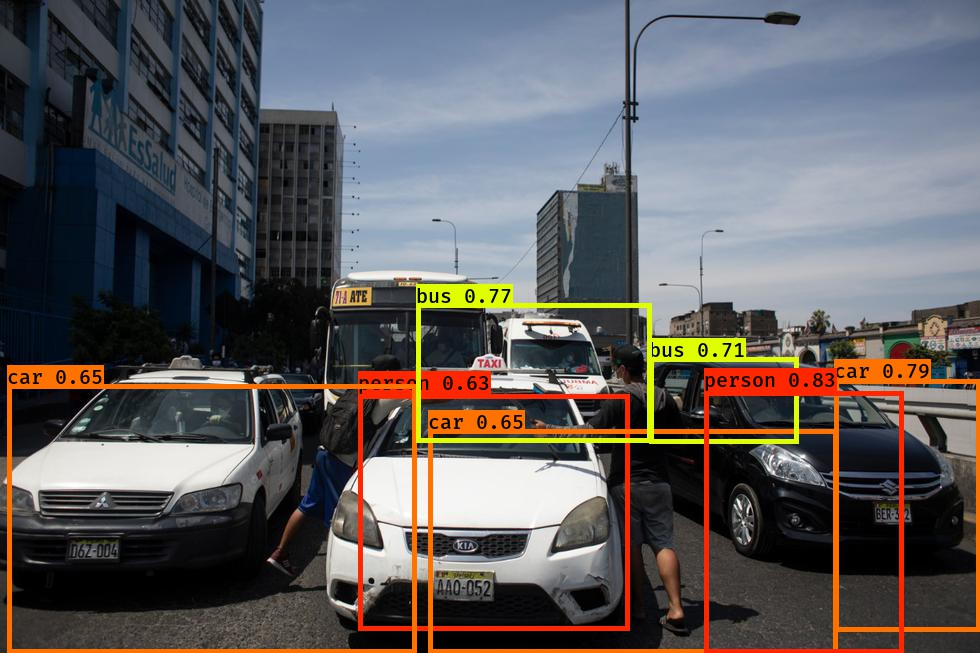

In [ ]:
out_scores, out_boxes, out_classes = predict(sess, "test3.jpg")